# Klassifisering
Klassifisering betegner prediksjon der vi prøver å tilordne en bestemt klasse av et begrenset utvalg. Det kan være å svare på et enkelt ja-nei-spørsmål, eller mer komplekse scenarier med mange klasser.

Vi begynner med å gjøre noen imports som er nødvendige for resten av koden i denne fila. Denne kan du bare kjøre uten å tenke så mye mer over hva den gjør 😉

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sklearn

## Support Vector Machines
Support Vector Machines (SVM) er en enkel, men likevel kraftig klassifiseringsteknikk som blant annet lenge var state-of-the-art for tekstgjenkjenning. SVM-er kan i utgangspunktet kun gjøre lineær klassifisering, altså klassifisering der klassene kan skilles med en rett linje. Imidlertid finnes det et triks kalt "kernel trick" som lar oss også utføre ikke-lineær klassifisering.

> *Trikset går ut på å mappe et ikke-lineært klassifiserbart problem til en høyere dimensjonalitet der den er klassifiserbar. Spesielt interesserte kan lese mer om det her: [https://en.wikipedia.org/wiki/Kernel_method](https://en.wikipedia.org/wiki/Kernel_method)*

### Datalasting
Vi begynner med et forholdsvis enkelt datasett over forskjellige typer vin, med tre klasser og 13 forskjellige andre egenskaper. Scikit-Learn har en innebygd hjelpefunksjon som enkelt lar oss laste dette datasettet:

In [30]:
wine_dict = sklearn.datasets.load_wine(as_frame=True)
df_wine = wine_dict['data']
wine_target = wine_dict['target']
df_wine = pd.concat([df_wine, wine_target], axis=1)
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


### Datautforskning

La oss se litt på hvordan klassefordelingen er basert på noen utvalgte variabler. Vi begynner enkelt, og velger ut de to variablene "alcohol" og "hue", og ser hvordan klassene fordeler seg basert på disse. (Det blir din oppgave å utforske videre hvordan andre variabler påvirker utfallet.)

For klassifisering passer det godt å bruke et scatterplot der fargen på hvert punkt angir klassen vi prøver å predikere:

<Axes: xlabel='alcohol', ylabel='hue'>

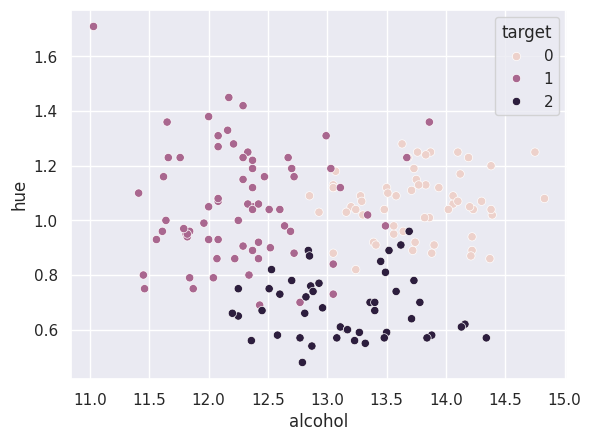

In [31]:
sns.scatterplot(data=df_wine, x='alcohol', y='hue', hue='target')

Det kan også være nyttig å ha et forhold til antall observasjoner av hver klasse. Dersom dette er veldig ubalansert, kan det være nødvendig med tiltak for at dette ikke skal påvirke treningen av modellen.

In [32]:
df_wine['target'].value_counts()

,count
target,
1,71
0,59
2,48


Det er litt ubalanse i antallet observasjoner, men ikke noe dramatisk, så vi prøver oss på å ikke gjøre noe med det.

### Klargjøring av datasett
Ofte gir det mening å gjøre preprosessering av datasettet for å tilrettelegge for en best mulig modell. En SVM kan være sensitiv for størrelsen på de forskjellige variablene, så det er god praksis å skalere alle til å være mellom 0 og 1.

In [33]:
scaled_df = df_wine.drop(columns='target')
scaler = sklearn.preprocessing.MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)
df_wine = pd.concat([scaled_df, df_wine['target']], axis=1)
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341,0
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642,0
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933,0
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347,0
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963,0


### Tilpasning til SVM
Dette datasettet inneholder tre forskjellige klasser. SVM-er kan kun gjøre binær klassifisering – det vil si at de kun kan skille mellom to klasser. Det finnes triks for å gjøre klassifisering mellom flere enn to klasser med SVM-er, men la oss begynne med å fjerne ene klassen for å få oppførselen til en helt enkel SVM.

In [34]:
df_wine_dual_class = df_wine[df_wine['target'] != 2]
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341,0
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642,0
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933,0
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347,0
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963,0


Dette ser ganske lovende ut! Vi har noen tydelige klynger med forskjellige klassene, og kan dermed forvente at en modell skal kunne få ganske gode resultater bare basert på disse to variablene. Det ser faktisk også ut som at selv en rett linje vil gjøre en ganske god jobb med å skille klassene, slik at vi kanskje kan få ganske gode resultater selv uten "kernel trick".

### Splitting av datasett
Vi splitter datasettet inn i trenings- og testsett slik at vi senere kan evaluere hvor godt modellen funker på datapunkter den ennå ikke har sett.

In [35]:
df_wine_train, df_wine_test = sklearn.model_selection.train_test_split(df_wine_dual_class, test_size=0.2, stratify=df_wine_dual_class['target'])

### Trening av modell
La oss lage en SVM-modell og trene den på treningssettet vårt! Vi prøver oss på en SVM-modell uten kernel trick til å begynne med.

In [36]:
variables = ['alcohol', 'hue']
wine_svm_model = sklearn.svm.SVC(kernel='linear')
wine_svm_model.fit(df_wine_train[variables], df_wine_train['target'])

SVC(kernel='linear')

### Testing av modellen
For regresjon brukte vi Mean Square Error for å teste hvor god modellen vår var. For klassifisering er ikke dette et like godt mål, da klassene våre ikke burde tolkes som en tallinje. Det er ikke mer feil å gjette klasse 1 enn klasse 2 dersom det var klasse 3 som var riktig – begge er 100% feil, uavhengig av hvor langt unna gjetningen tilfeldigvis var numerisk.

Målet vi bruker er i stedet "accuracy" – altså i hvor stor prosentandel av observasjonene traff vi på riktig klasse.

In [37]:
wine_pred_train = wine_svm_model.predict(df_wine_train[variables])
wine_pred_test = wine_svm_model.predict(df_wine_test[variables])

train_accuracy = sklearn.metrics.accuracy_score(df_wine_train['target'], wine_pred_train)
test_accuracy = sklearn.metrics.accuracy_score(df_wine_test['target'], wine_pred_test)

print(f'Accuracy, treningsdata: {train_accuracy:.2f}')
print(f'Accuracy, testdata: {test_accuracy:.2f}')

Accuracy, treningsdata: 0.92
Accuracy, testdata: 0.88


Vi ser at vi får veldig gode resultater! Dette er ikke veldig overraskende, siden dette er et forholdsvis enkelt problem.

### Visualisering av resultat
Vi kan prøve oss på å visualisere resultatet litt for å se hvor det er modellen tar feil:

<Axes: xlabel='alcohol', ylabel='hue'>

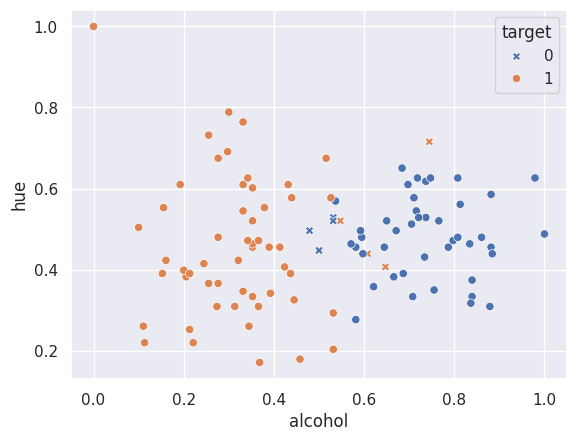

In [38]:
sns.scatterplot(data=df_wine_train, x='alcohol', y='hue', hue='target', style=(df_wine_train['target'] == wine_pred_train), markers=['X', 'o'])

<Axes: xlabel='alcohol', ylabel='hue'>

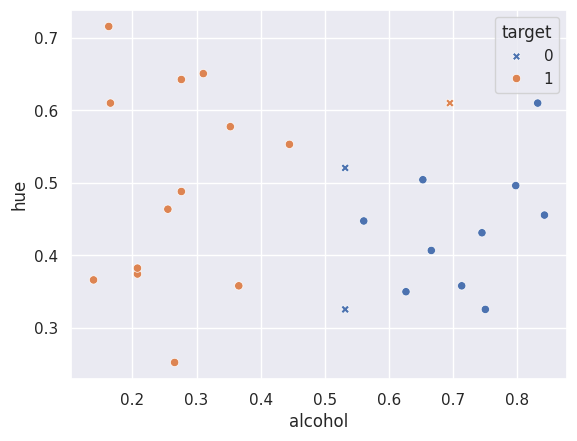

In [39]:
sns.scatterplot(data=df_wine_test, x='alcohol', y='hue', hue='target', style=(df_wine_test['target'] == wine_pred_test), markers=['X', 'o'])

Observasjonene som har blitt klassifisert feil ligger i grenseflaten mellom klassene, og det kan se ut som at det stemmer godt med at modellen har trukket en rett linje mellom klassene, noe som ikke er mulig å gjøre uten at noen av observasjonene havner på feil sted.

### Vi gjeninnfører den tredje klassen
Okey, problemet ble så enkelt at det nesten var kjedelig når vi reduserte antallet klasser til to. La oss gjeninnføre den tredje klassen, og se hvordan vi kan få dette til å funke med en SVM-modell. Heldigvis har scikit-learn allerede håndtert dette for oss!

In [40]:
df_wine_train, df_wine_test = sklearn.model_selection.train_test_split(df_wine, test_size=0.2, stratify=df_wine['target'])

### Trening av modell
Det kreves kun én liten tilpasning for å la scikit-learn bruke SVM for å predikere mer enn to klasser, og det er at vi setter en parameteret "decision function shape". Det som skjer under panseret er at scikit-learn deler opp problemet i flere underproblemer som i seg selv er binære, og trener opp flere SVM-modeller. Med strategien "ovo", som står for one-versus-one, sier vi at den skal trene opp modeller for å sammenlikne to og to av klassene. (Denne er som standard satt til "ovr", som står for one-versus-rest og også ville funket, men det er fint å sette det eksplisitt mens man lærer seg hva som egentlig foregår.)

Vi prøver oss på å fortsatt ha en lineær kjernefunksjon, for å se hvor godt dette funker på tre klasser.

In [41]:
variables = ['alcohol', 'hue']
wine_svm_model = sklearn.svm.SVC(decision_function_shape='ovo', kernel='linear')
wine_svm_model.fit(df_wine_train[variables], df_wine_train['target'])

SVC(decision_function_shape='ovo', kernel='linear')

### Testing av modellen
Vi tester resultatet på samme måte som før:

In [42]:
wine_pred_train = wine_svm_model.predict(df_wine_train[variables])
wine_pred_test = wine_svm_model.predict(df_wine_test[variables])

train_accuracy = sklearn.metrics.accuracy_score(df_wine_train['target'], wine_pred_train)
test_accuracy = sklearn.metrics.accuracy_score(df_wine_test['target'], wine_pred_test)

print(f'Accuracy, treningsdata: {train_accuracy:.2f}')
print(f'Accuracy, testdata: {test_accuracy:.2f}')

Accuracy, treningsdata: 0.85
Accuracy, testdata: 0.94


### Visualisering av resultat

<Axes: xlabel='alcohol', ylabel='hue'>

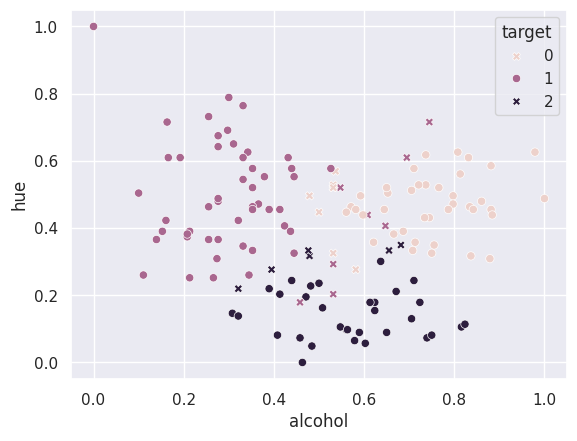

In [43]:
sns.scatterplot(data=df_wine_train, x='alcohol', y='hue', hue='target', style=(df_wine_train['target'] == wine_pred_train), markers=['X', 'o'])

<Axes: xlabel='alcohol', ylabel='hue'>

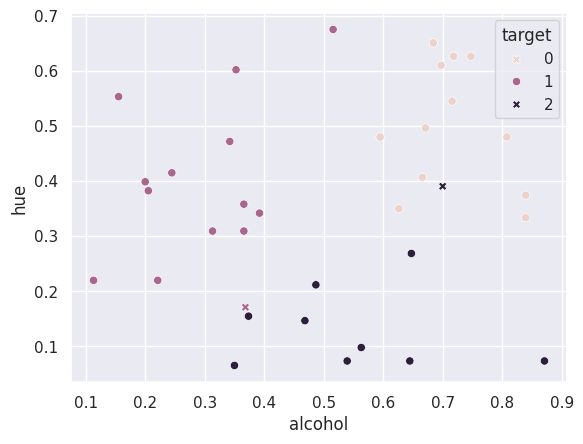

In [44]:
sns.scatterplot(data=df_wine_test, x='alcohol', y='hue', hue='target', style=(df_wine_test['target'] == wine_pred_test), markers=['X', 'o'])

### Oppgave: Prøv å forbedre modellen
Vi får allerede ganske gode resultater, men det er også en del variabler vi ikke har brukt. Vi har heller ikke brukt noen kjernefunksjon foreløpig, så all klassifisering har vært lineært. Klarer du å forbedre resultatet ytterligere?

## Decision Trees
Decision trees, eller beslutningstrær, er en annen anvendelig modelltype. En stor fordel med beslutningstrær er at de er lette å lese for et menneske, siden de består av en rekke lett forståelige beslutninger. Med riktig teknikker er det også en kraftig modelltype.

### Datalasting
Denne gangen tar vi en titt på Iris-datasettet, som er et enkelt datasett for klassifisering av blomster av typen Iris basert på noen mål.

In [45]:
df_iris_dict = sklearn.datasets.load_iris(as_frame=True)
df_iris = df_iris_dict['data']
df_iris['target'] = df_iris_dict['target']
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Datasplitting
Nok en gang splitter vi datasettet i trenings- og testsett, slik at vi kan se hvor godt modellen generaliserer.

In [46]:
df_iris_train, df_iris_test = sklearn.model_selection.train_test_split(df_iris, test_size=0.2, stratify=df_iris['target'])

### Trening av modellen
Vi oppretter og trener modellen. Beslutningstrær er ganske enkle modeller, og i dette tilfellet bruker vi rett og slett bare standardparameterene som sklearn gir oss. Treningskoden er derfor veldig enkel.

In [47]:
iris_dt_model = sklearn.tree.DecisionTreeClassifier()
iris_dt_model.fit(df_iris_train.drop(columns='target'), df_iris_train['target'])

DecisionTreeClassifier()

### Evaluering
La oss se på hvordan modellen gjør det:

In [48]:
iris_pred_train = iris_dt_model.predict(df_iris_train.drop(columns='target'))
iris_pred_test = iris_dt_model.predict(df_iris_test.drop(columns='target'))

train_accuracy = sklearn.metrics.accuracy_score(df_iris_train['target'], iris_pred_train)
test_accuracy = sklearn.metrics.accuracy_score(df_iris_test['target'], iris_pred_test)

print(f'Accuracy, treningsdata: {train_accuracy:.2f}')
print(f'Accuracy, testdata: {test_accuracy:.2f}')

Accuracy, treningsdata: 1.00
Accuracy, testdata: 1.00


Her ser vi at modellen treffer godt både på trenings- og testdatasettet, og utfra våre observasjoner ser det ikke ut til at modellen overfitter nevneverdig. Vi har her trent på et ganske enkelt datasett, så dette er som forventet. Beslutningstrær har imidlertid en tendens til å overfitte dersom vi ikke setter begrensninger på hvordan de trenes opp, så det er en ting å være obs på når man jobber med slike modeller.

### Visualisering av modellen
En stor fordel med beslutningstrær er som nevnt at de er nokså enkle å forstå, og SKLearn gir en enkel måte å visualisere trærne på.

[Text(0.5, 0.9166666666666666, 'x[3] <= 0.8\ngini = 0.667\nsamples = 120\nvalue = [40, 40, 40]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 40\nvalue = [40, 0, 0]'),
 Text(0.46153846153846156, 0.8333333333333333, 'True  '),
 Text(0.5769230769230769, 0.75, 'x[3] <= 1.75\ngini = 0.5\nsamples = 80\nvalue = [0, 40, 40]'),
 Text(0.5384615384615384, 0.8333333333333333, '  False'),
 Text(0.3076923076923077, 0.5833333333333334, 'x[2] <= 4.95\ngini = 0.201\nsamples = 44\nvalue = [0, 39, 5]'),
 Text(0.15384615384615385, 0.4166666666666667, 'x[3] <= 1.65\ngini = 0.051\nsamples = 38\nvalue = [0, 37, 1]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 37\nvalue = [0, 37, 0]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.46153846153846156, 0.4166666666666667, 'x[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.5384615384615384, 0.25, 'x

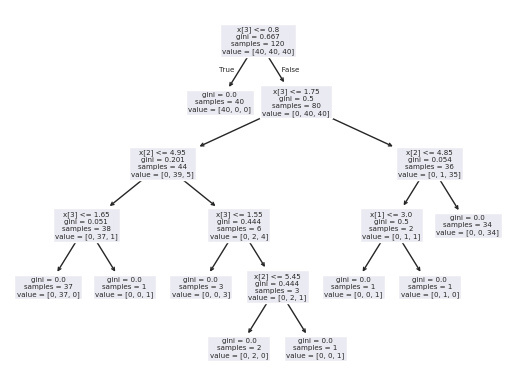

In [49]:
sklearn.tree.plot_tree(iris_dt_model)

Her er det en del tall som kan være litt vanskelige å forstå. Linjene som ser ut som `x[3] < 0.8` eller liknende viser beslutningen som evalueres i nodene, og hvilken gren man følger ut representerer resultatet av denne. Gini er en indeks som brukes i prosessen med å trene opp treet, og sier noe om hvor godt noden deler opp dataene. Samples viser totalt antall samples i treningsdataene som passerte gjennom denne noden, og value viser fordelingen av disse på de tre klassene.

## Random Forests
Vi kunne prøvd å fininnstille den forrige modellen mer, men der beslutningstrær virkelig skinner er når vi bruker dem i ensemble learning – altså at vi trener opp flere modeller som til sammen bestemmer prediksjonen. Den enkleste formen for dette er Random Forests, der vi trener opp en rekke beslutningstrær som hver gjør prediksjoner basert på et tilfeldig valgt subsett både av samples og features. Dette gjør hver enkelt modell svakere, men dette veies opp ved at vi regner ut den endelige beslutningen ved å la alle modellene stemme. Dette bygger på antagelsen om at det er veldig lite sannsynlig at alle modellen tar feil på samme måte!

Siden vi har gjort hver enkelt modell svakere, reduserer vi risikoen for overfitting. Samtidig vil ofte hele ensemblet til sammen gi mer nøyaktige resultater enn én modell alene.

### Datalasting
Denne gangen skal vi se på et mer komplekst datasett, som inneholder håndskrevne tall. Vi skal rett og slett prøve oss på enkel tekstgjenkjenning!

In [50]:
digits_dict = sklearn.datasets.load_digits(as_frame=True)
df_digits = digits_dict['data']
df_digits['target'] = digits_dict['target']
df_digits.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


Siden dataene denne gangen er bilder, kan det være spennende å se hvordan et utvalg ser ut:

<function matplotlib.pyplot.show(close=None, block=None)>

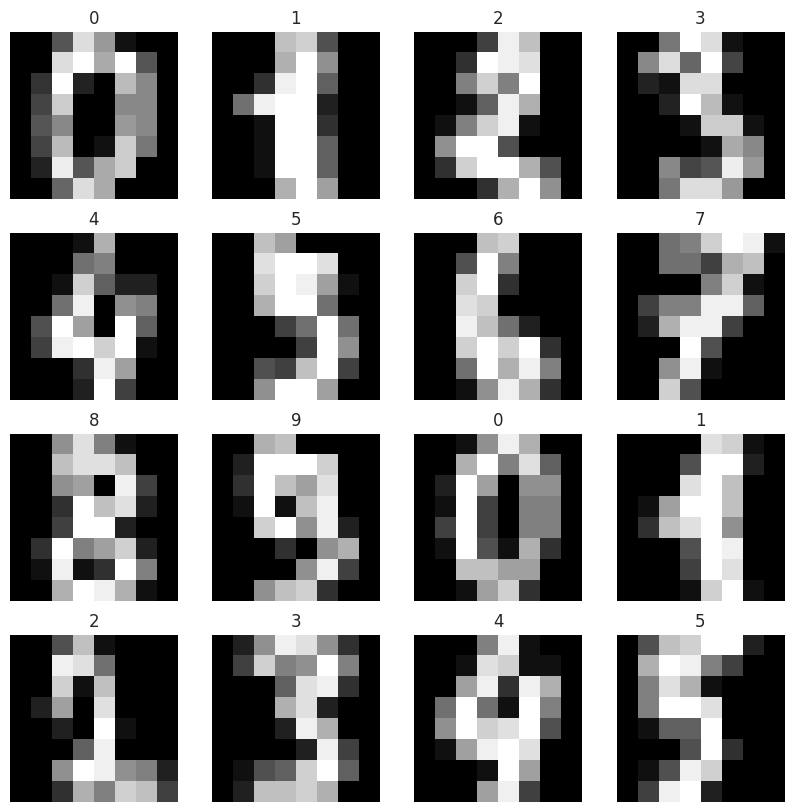

In [51]:
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = df_digits.iloc[i, :-1].values.reshape(8, 8)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(df_digits.iloc[i, -1])
plt.show

### Splitting av datasett
Vi splitter opp datasettet, som vanlig:

In [52]:
df_digits_train, df_digits_test = sklearn.model_selection.train_test_split(df_digits, test_size=0.2, stratify=df_digits['target'])

### Trening av modell
Vi oppretter og trenger modellen. Her har jeg med vilje gjørt modellen veldig svak med hvordan parameterne har blitt satt, så det kan være at du må endre noe for å få gode verdier!

In [62]:
digits_rf_model = sklearn.ensemble.RandomForestClassifier(n_estimators=25, max_features=4, max_depth=4)
digits_rf_model.fit(df_digits_train.drop(columns='target'), df_digits_train['target'])

RandomForestClassifier(max_depth=4, max_features=4, n_estimators=25)

### Evaluering
Vi ser på hvor godt modellen gjorde det:

In [63]:
digits_train_pred = digits_rf_model.predict(df_digits_train.drop(columns='target'))
digits_test_pred = digits_rf_model.predict(df_digits_test.drop(columns='target'))

train_accuracy = sklearn.metrics.accuracy_score(df_digits_train['target'], digits_train_pred)
test_accuracy = sklearn.metrics.accuracy_score(df_digits_test['target'], digits_test_pred)

print(f'Accuracy, treningsdata: {train_accuracy:.2f}')
print(f'Accuracy, testdata: {test_accuracy:.2f}')

Accuracy, treningsdata: 0.91
Accuracy, testdata: 0.90


Hvis du ikke endret på noe over, vil du få veldig dårlige resultater. Prøv å gå tilbake og forbedre de!

### Hvilke features er viktigst?
En spennende ting med random forests er at måten de trenes og gjør prediksjoner gjør at vi kan få et mål på hvor viktig forskjellige features er. La oss prøve å lage en visualisering av dette!

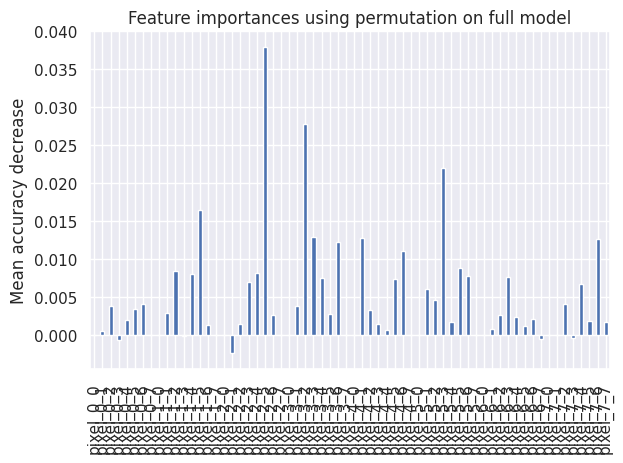

In [65]:
importance_result = sklearn.inspection.permutation_importance(digits_rf_model, df_digits_train.drop(columns='target'), df_digits_train['target'], n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(importance_result.importances_mean, index=df_digits_train.drop(columns='target').columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

For dette datasettet, med 8x8 pixler som features, er det ikke kjempelett å lese dette plottet, men med en godt tilpasset modell burde du likevel kunne set at det er noen pixler som er langt viktigere enn andre for å bestemme hvilket tall det ser snakk om.

Vi kan prøve et heatmap for å kanskje gjøre det litt lettere å tolke:

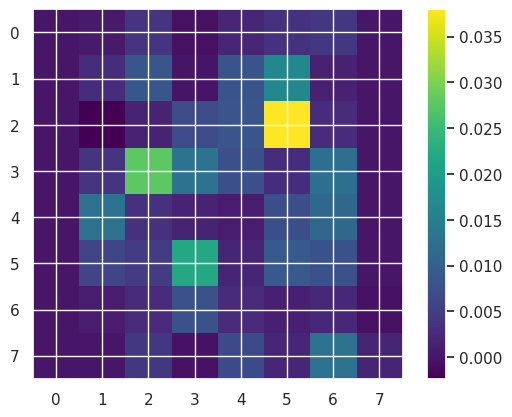

In [66]:
# Plot heatmap of importances
plt.imshow(forest_importances.values.reshape(8, 8), cmap='viridis')
plt.colorbar()

Her burde du kunne se en klar tendens til at pixler omtrent der tallet som regel er skrevet er langt viktigere enn pixler langs kanten der det ofte er blankt.

### Ekstraoppgaver
SKLearn inneholder mange flere datasett (https://scikit-learn.org/stable/api/sklearn.datasets.html), så prøv deg gjerne på noen av disse! Det finnes også flere modeller det går an leke seg med – se i API-referansen for å finne disse: https://scikit-learn.org/stable/api/index.html